#### **Final Project for "📸Introduction to Computer Vision"**
## **Классификация опухолей головного мозга с использованием МРТ-сканирования**

### 0. 📥 Imports

In [38]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import tensorflow as tf
from tensorflow import keras
import PIL
import pathlib
import PIL.Image
import warnings
from datetime import datetime
import random
from pathlib import Path
import matplotlib.pyplot as plt
# Импортируем необходимые библиотеки
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization, 
    Activation, 
    MaxPooling2D, 
    Dense, 
    GlobalAveragePooling2D, 
    Add,
)
warnings.filterwarnings("ignore")


### 1. 📊 Problem Understanding and Dataset Selection:
#### **Определение проблемы:**
Целью этого проекта является классификация МРТ-сканов мозга по одной из следующих четырех категорий:
1. **Glioma - Глиома**
2. **Healthy - Здоровый**
3. **Meningioma - Менингиома**
4. **Pituitary - Гипофиз**

Эта задача классификации имеет решающее значение для ранней диагностики и планирования лечения опухолей головного мозга, что может спасти жизни.

### **Обзор набора данных** 

Всего **7023 МРТ-сканов мозга**, разделенных на четыре класса.
1. **Glioma - Глиома**: 1,621 изображения {./dataset/glioma} 
2. **Healthy - Здоровый**: 2,000 изображения {./dataset/healthy}
3. **Meningioma - Менингиома**: 1,645 изображения {./dataset/meningioma} 
4. **Pituitary - Гипофиз**: 1,757 изображения {./dataset/pituitary}

Каждое изображение **изображение RGB размером 224x224 пикселей**, что обеспечивает достаточное разрешение для извлечения признаков с использованием методов глубокого обучения.
 
Я выбрала датасет с Kaggle, так как могу продемонстрировать свои знания и работать над задачей классификации типов опухолей, что, возможно, будет полезно как для меня, так и для других.

In [ ]:
# аутентификация с токеном - расположенный на пути C:\Users\Qarlygash\.kaggle\kaggle.json
api = KaggleApi()
api.authenticate()

api.dataset_download_files("rm1000/brain-tumor-mri-scans", path="./dataset", unzip=True)

In [39]:
# проверила правильно ли кол-во изображений скачалось
dataset_path = "./dataset"
classes = ["glioma", "healthy", "meningioma", "pituitary"]

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_path))
    print(f"{cls.capitalize()}: {num_images} images")


Glioma: 1621 images
Healthy: 2000 images
Meningioma: 1645 images
Pituitary: 1757 images


### 2. 🔄 Data Preprocessing:
#### **Предпринятые действия:**
1. **Очистка данных:** Гарантировано отсутствие поврежденных или отсутствующих файлов.
2. **Нормализация:** Значения пикселей масштабированы до диапазона [0, 1].
3. **Augmentation:** Применено случайное переворачивание, регулировка яркости, изменение контрастности и обрезка для обучающих данных для улучшения обобщения модели.
4. **Разделение данных:**
- Обучающий набор: 80%
- Проверочный набор: 10%
- Тестовый набор: 10%

In [40]:
# Параметры
BATCH_SIZE = 2
IMAGE_SIZE = (224, 224)
dataset_path = "./dataset"
classes = ["glioma", "healthy", "meningioma", "pituitary"]

In [137]:
# # Функция для разделения данных
# def split_data():
#     train_data = []
#     val_data = []
#     test_data = []

#     for cls in classes:
#         class_dir = os.path.join(dataset_path, cls)
#         images = os.listdir(class_dir)

#         # Разделение на train, validation, test
#         num_images = len(images)
#         train_split = int(num_images * 0.8)
#         val_split = int(num_images * 0.9)

#         train_images = images[:train_split]
#         val_images = images[train_split:val_split]
#         test_images = images[val_split:]

#         train_data.extend([(os.path.join(class_dir, img), cls) for img in train_images])
#         val_data.extend([(os.path.join(class_dir, img), cls) for img in val_images])
#         test_data.extend([(os.path.join(class_dir, img), cls) for img in test_images])

#     return train_data, val_data, test_data

# # Подготовка датасета для TensorFlow
# def prepare_dataset(data):
#     file_paths, labels = zip(*data)
#     labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))

#     dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

#     # Преобразование изображений
#     dataset = dataset.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), IMAGE_SIZE), y))
#     dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
#     return dataset

# # Разделение данных
# train_data, val_data, test_data = split_data()

# # Подготовка наборов данных
# train_ds = prepare_dataset(train_data)
# val_ds = prepare_dataset(val_data)
# test_ds = prepare_dataset(test_data)


In [41]:
#2я версия с ResNet50 Была правильной
def split_data():
    train_data = []
    val_data = []
    test_data = []

    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = os.listdir(class_dir)

        # Разделение на train, validation, test
        num_images = len(images)
        train_split = int(num_images * 0.8)
        val_split = int(num_images * 0.9)

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        train_data.extend([(os.path.join(class_dir, img), cls) for img in train_images])
        val_data.extend([(os.path.join(class_dir, img), cls) for img in val_images])
        test_data.extend([(os.path.join(class_dir, img), cls) for img in test_images])

    return train_data, val_data, test_data

# Функция для обработки изображений (с изменением размера, нормализацией и аугментацией)
def prepare_dataset(data, is_train=False):
    file_paths, labels = zip(*data)
    labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))

    dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

    # Преобразование изображений с аугментацией для тренировочных данных
    def process_image(file_path, label):
        image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
        image = tf.image.resize(image, IMAGE_SIZE)

        # Нормализация изображений (диапазон [0, 1])
        image = image / 255.0

        # Аугментация для тренировочных данных
        if is_train:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)

        return image, label


    dataset = dataset.map(process_image)

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Функция для визуализации изображений
def display_image_from_dataset(dataset):
    for image_batch, label_batch in dataset.take(1):  # Берём один батч
        image = image_batch[0].numpy()  # Получаем первое изображение из батча
        label = label_batch[0].numpy()  # Получаем метку первого изображения из батча

        # Декодируем метку из one-hot в индекс
        class_index = tf.argmax(label).numpy()
        class_name = classes[class_index]  # Сопоставляем индекс с именем класса

        # Обратная нормализация изображения
        # Обратная нормализация
        image = (image * 255).astype("uint8")  # Преобразование в [0, 255]

        # Отображаем изображение
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis("off")
        plt.show()
        break  # Прерываем, чтобы взять только один батч

# Разделение данных
train_data, val_data, test_data = split_data()

# Подготовка наборов данных
train_ds = prepare_dataset(train_data, is_train=True)
val_ds = prepare_dataset(val_data, is_train=False)
test_ds = prepare_dataset(test_data, is_train=False)



Preparing training dataset...
Preparing validation dataset...
Preparing test dataset...


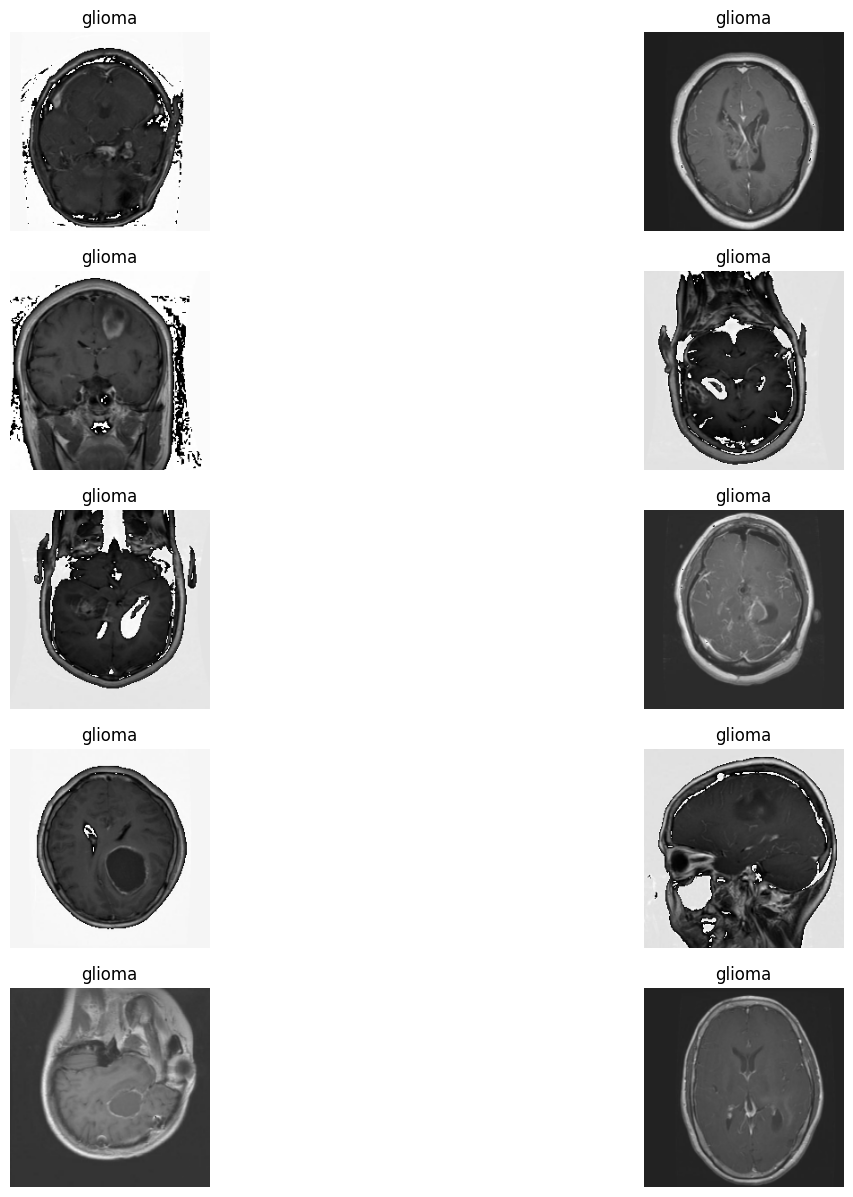

In [9]:
# Здесь получается без shuffle
import matplotlib.pyplot as plt

# Функция для разделения данных
def split_data():
    train_data = []
    val_data = []
    test_data = []

    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = os.listdir(class_dir)

        # Разделение на train, validation, test
        num_images = len(images)
        train_split = int(num_images * 0.8)
        val_split = int(num_images * 0.9)

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        train_data.extend([(os.path.join(class_dir, img), cls) for img in train_images])
        val_data.extend([(os.path.join(class_dir, img), cls) for img in val_images])
        test_data.extend([(os.path.join(class_dir, img), cls) for img in test_images])

    # Проверка уникальности данных
    assert len(set(train_data).intersection(set(val_data))) == 0, "Train and Val data overlap"
    assert len(set(val_data).intersection(set(test_data))) == 0, "Val and Test data overlap"
    assert len(set(train_data).intersection(set(test_data))) == 0, "Train and Test data overlap"

    return train_data, val_data, test_data

# Функция для обработки изображений (с изменением размера, нормализацией и аугментацией)
def prepare_dataset(data, is_train=False):
    file_paths, labels = zip(*data)
    labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))

    dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

    # Преобразование изображений с аугментацией для тренировочных данных
    def process_image(file_path, label):
        try:
            image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
            image = tf.image.resize(image, IMAGE_SIZE)

            # Нормализация изображений (диапазон [0, 1])
            image = image / 255.0

            # Аугментация для тренировочных данных
            if is_train:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_flip_up_down(image)
                image = tf.image.random_brightness(image, max_delta=0.2)
                image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
                image = tf.image.random_crop(image, size=[int(IMAGE_SIZE[0] * 0.9), int(IMAGE_SIZE[1] * 0.9), 3])
                image = tf.image.resize(image, IMAGE_SIZE)

            return image, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return None, None

    dataset = dataset.map(process_image)
    dataset = dataset.filter(lambda x, y: x is not None and y is not None)

    # Кэширование, перемешивание и предварительная выборка
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Функция для визуализации изображений
def display_images_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, (image_batch, label_batch) in enumerate(dataset.take(num_images)):
        for j in range(len(image_batch)):
            plt.subplot(num_images, len(image_batch), i * len(image_batch) + j + 1)
            image = image_batch[j].numpy()
            label = tf.argmax(label_batch[j]).numpy()
            plt.imshow((image * 255).astype("uint8"))
            plt.title(classes[label])
            plt.axis("off")
    plt.show()

# Разделение данных
train_data, val_data, test_data = split_data()

# Подготовка наборов данных
print("Preparing training dataset...")
train_ds = prepare_dataset(train_data, is_train=True)

print("Preparing validation dataset...")
val_ds = prepare_dataset(val_data, is_train=False)

print("Preparing test dataset...")
test_ds = prepare_dataset(test_data, is_train=False)

# Визуализация изображений из тренировочного набора
display_images_from_dataset(train_ds)


Preparing training dataset...
Preparing validation dataset...
Preparing test dataset...


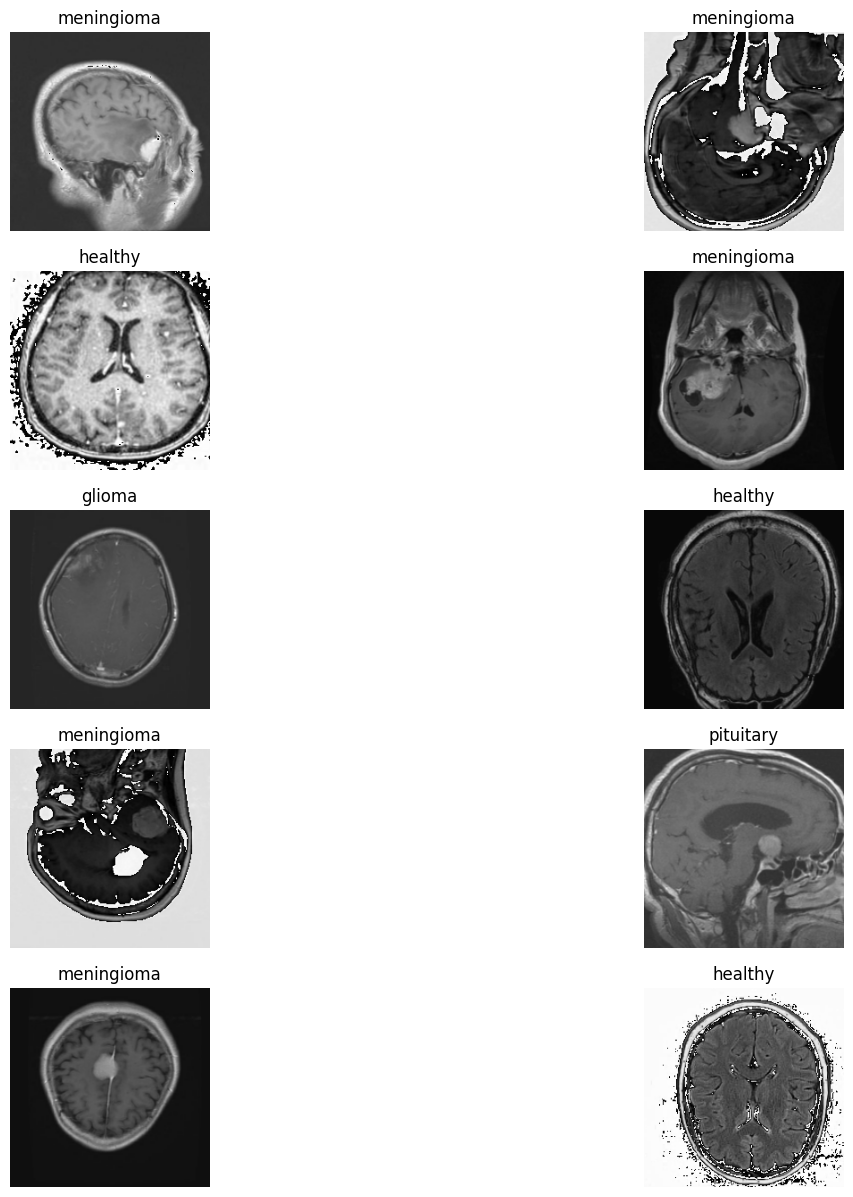

In [10]:
# Функция для разделения данных с перемешиванием
def split_data():
    all_data = []
    
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = os.listdir(class_dir)
        
        # Перемешиваем изображения внутри класса
        random.shuffle(images)
        
        # Добавляем изображения в общий список с метками классов
        all_data.extend([(os.path.join(class_dir, img), cls) for img in images])
    
    # Перемешиваем все данные, чтобы не было зависимости по классам
    random.shuffle(all_data)
    
    # Разделение на train, validation, test
    num_images = len(all_data)
    train_split = int(num_images * 0.8)
    val_split = int(num_images * 0.9)
    
    train_data = all_data[:train_split]
    val_data = all_data[train_split:val_split]
    test_data = all_data[val_split:]
    
    # Проверка уникальности данных
    assert len(set(train_data).intersection(set(val_data))) == 0, "Train and Val data overlap"
    assert len(set(val_data).intersection(set(test_data))) == 0, "Val and Test data overlap"
    assert len(set(train_data).intersection(set(test_data))) == 0, "Train and Test data overlap"
    
    return train_data, val_data, test_data

# Функция для обработки изображений (с изменением размера, нормализацией и аугментацией)
def prepare_dataset(data, is_train=False):
    file_paths, labels = zip(*data)
    labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))

    dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

    # Преобразование изображений с аугментацией для тренировочных данных
    def process_image(file_path, label):
        try:
            image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
            image = tf.image.resize(image, IMAGE_SIZE)

            # Нормализация изображений (диапазон [0, 1])
            image = image / 255.0

            # Аугментация для тренировочных данных
            if is_train:
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_flip_up_down(image)
                image = tf.image.random_brightness(image, max_delta=0.2)
                image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
                image = tf.image.random_crop(image, size=[int(IMAGE_SIZE[0] * 0.9), int(IMAGE_SIZE[1] * 0.9), 3])
                image = tf.image.resize(image, IMAGE_SIZE)

            return image, label
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return None, None

    dataset = dataset.map(process_image)
    dataset = dataset.filter(lambda x, y: x is not None and y is not None)

    # Кэширование, перемешивание и предварительная выборка
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Функция для визуализации изображений
def display_images_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, (image_batch, label_batch) in enumerate(dataset.take(num_images)):
        for j in range(len(image_batch)):
            plt.subplot(num_images, len(image_batch), i * len(image_batch) + j + 1)
            image = image_batch[j].numpy()
            label = tf.argmax(label_batch[j]).numpy()
            plt.imshow((image * 255).astype("uint8"))
            plt.title(classes[label])
            plt.axis("off")
    plt.show()

# Разделение данных с перемешиванием
train_data, val_data, test_data = split_data()

# Подготовка наборов данных
print("Preparing training dataset...")
train_ds = prepare_dataset(train_data, is_train=True)

print("Preparing validation dataset...")
val_ds = prepare_dataset(val_data, is_train=False)

print("Preparing test dataset...")
test_ds = prepare_dataset(test_data, is_train=False)

# Визуализация изображений из тренировочного набора
display_images_from_dataset(train_ds)

In [11]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>


In [42]:
# Получаем один батч из PrefetchDataset
for image_batch, label_batch in train_ds.take(1):  # Берём один батч
    # Выбираем первое изображение и метку
    image_tensor = image_batch[0]  # Первое изображение
    label_tensor = label_batch[0]  # Первая метка

    # Печатаем значения тензора изображения
    print("Image tensor shape:", image_tensor.shape)  # Размерность изображения
    print("Image tensor values (flattened):", tf.reshape(image_tensor, [-1]).numpy())  # Плоский список значений

    # Если хотите отобразить байты в стиле "pixel_values", можно преобразовать тензор в байты
    image_bytes = tf.io.encode_jpeg(tf.cast(image_tensor * 255, tf.uint8))  # Конвертация в JPEG
    print("Pixel values as bytes:", image_bytes.numpy())  # Байтовое представление

    # Для меток
    print("Label tensor:", label_tensor.numpy())  # Метка в формате numpy

    # Прерываем цикл после одного батча
    break


Image tensor shape: (224, 224, 3)
Image tensor values (flattened): [0. 0. 0. ... 0. 0. 0.]
Pixel values as bytes: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xe0\x00\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x1

Здесь видно что изображение в формате RGB, поскольку размер тензора указан как (224, 224, 3). Третий размер 3 указывает на три цветовых канала: Red (красный), Green (зеленый) и Blue (синий), что соответствует формату RGB.

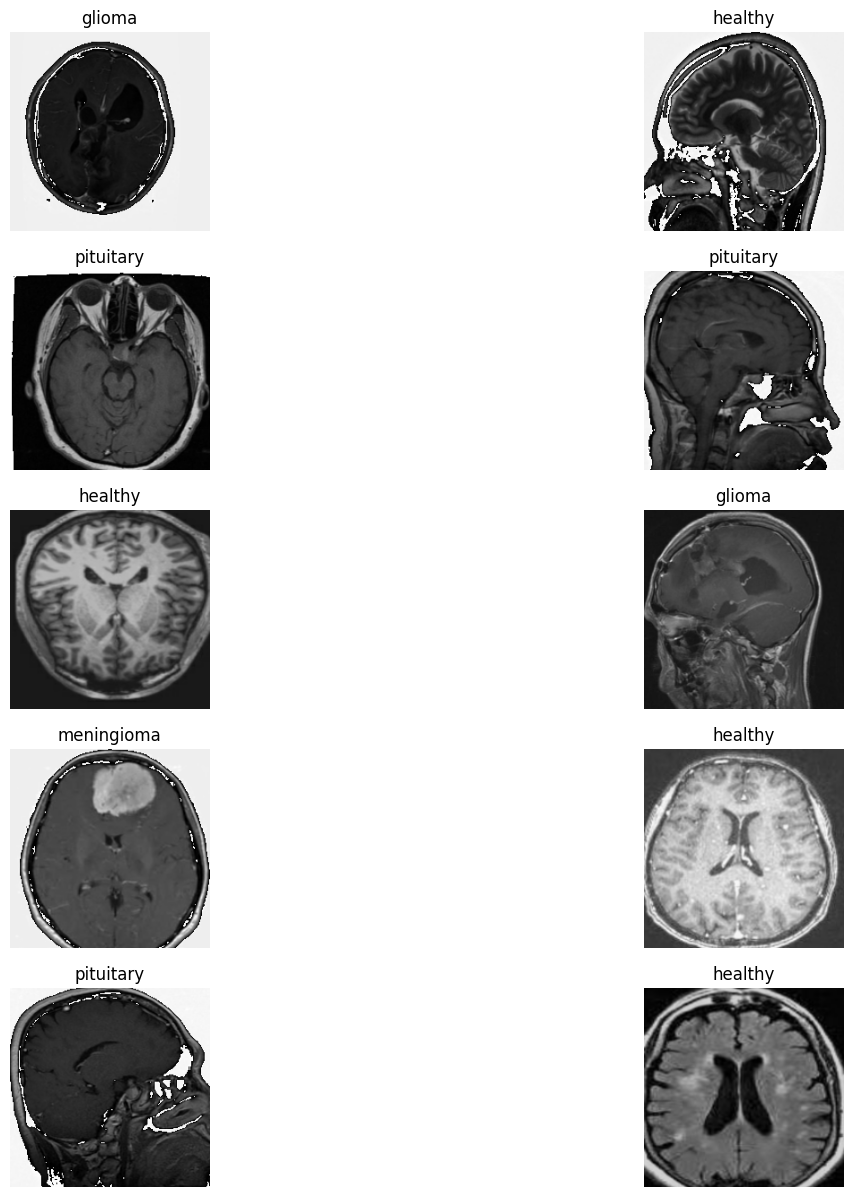

In [14]:
# Визуализация примера изображения из тренировочного набора
display_images_from_dataset(train_ds)

In [26]:
# Последняя версия
def split_data():
    all_data = []
    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = os.listdir(class_dir)
        random.shuffle(images)
        all_data.extend([(os.path.join(class_dir, img), cls) for img in images])
    random.shuffle(all_data)
    num_images = len(all_data)
    train_split = int(num_images * 0.8)
    val_split = int(num_images * 0.9)
    train_data = all_data[:train_split]
    val_data = all_data[train_split:val_split]
    test_data = all_data[val_split:]
    return train_data, val_data, test_data

train_data, val_data, test_data = split_data()

def prepare_dataset(data, is_train=False):
    file_paths, labels = zip(*data)
    labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))
    dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

    def process_image(file_path, label):
        image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
        image = tf.image.resize(image, IMAGE_SIZE) / 255.0
        if is_train:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return image, label

    dataset = dataset.map(process_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = prepare_dataset(train_data, is_train=True)
val_ds = prepare_dataset(val_data, is_train=False)
test_ds = prepare_dataset(test_data, is_train=False)

In [27]:
# Функция для визуализации изображений
def display_images_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(15, 15))
    image_count = 0

    for image_batch, label_batch in dataset:
        for i in range(len(image_batch)):
            if image_count >= num_images:
                break
            plt.subplot(1, num_images, image_count + 1)
            image = image_batch[i].numpy()
            label = tf.argmax(label_batch[i]).numpy()
            plt.imshow((image * 255).astype("uint8"))
            plt.title(classes[label])
            plt.axis("off")
            image_count += 1
        if image_count >= num_images:
            break
    plt.show()

#### **Visualizations:**

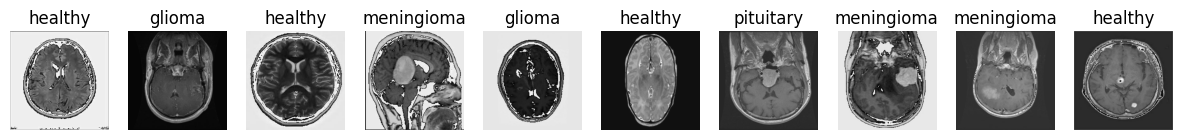

In [29]:
# Визуализация примеров изображений из тренировочного набора данных
display_images_from_dataset(train_ds, num_images=10)

In [185]:
# Преобразуем датасет в список для получения первых 5 элементов
data = list(train_ds.take(1))  # Возьмём первые 5 батчей
for image_batch, label_batch in data:
    for i in range(len(image_batch)):  # Проходим по изображениям внутри батча
        image = image_batch[i].numpy()  # Извлекаем изображение
        label_index = tf.argmax(label_batch[i]).numpy()  # Находим индекс класса
        print(image.shape, classes[label_index])  # Печатаем форму изображения и класс
        break

(224, 224, 3) glioma


In [16]:
# Печатаем несколько изображений из train_ds, чтобы убедиться, что они перемешаны
for image_batch, label_batch in train_ds.take(1):  # Берем один батч
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()
        label_index = tf.argmax(label_batch[i]).numpy()
        print(image.shape, classes[label_index])

(224, 224, 3) healthy
(224, 224, 3) glioma


In [17]:
import random
import numpy as np

# Преобразуем датасет в единый список изображений и меток
all_images = []
for image_batch, label_batch in train_ds:
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()  # Извлекаем изображение
        label_index = tf.argmax(label_batch[i]).numpy()  # Находим индекс класса
        all_images.append((image, label_index))  # Сохраняем пару (изображение, класс)

# Случайно выбираем 5 изображений
random_samples = random.sample(all_images, 5)

# Выводим информацию о случайно выбранных изображениях
for image, label_index in random_samples:
    print(image.shape, classes[label_index])  # Печатаем форму изображения и класс


(224, 224, 3) pituitary
(224, 224, 3) meningioma
(224, 224, 3) pituitary
(224, 224, 3) meningioma
(224, 224, 3) healthy


### 3. 🧠 Model Selection and Implementation:

* CNN
* ResNet50

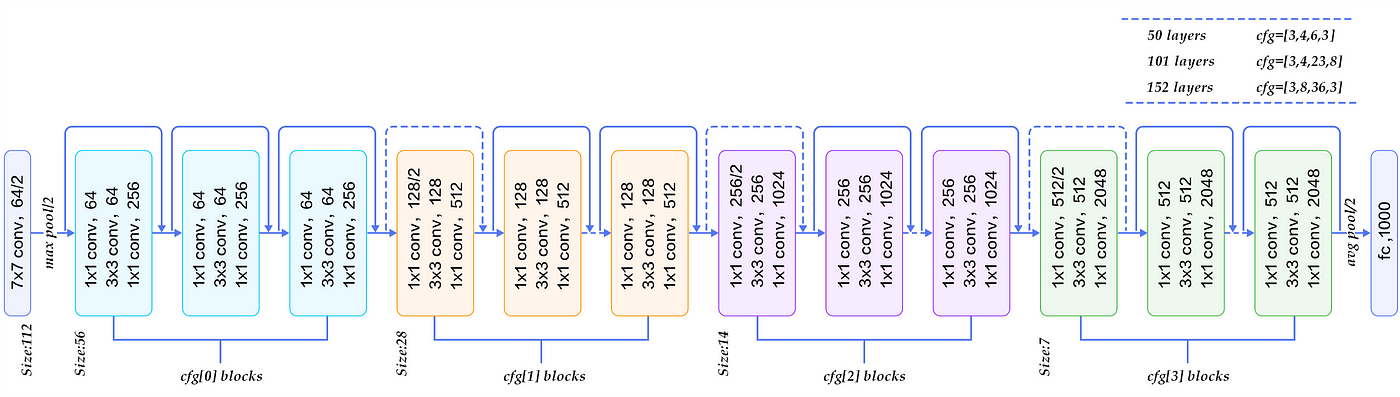

Создание модели ResNet50...
Обучение модели...
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 5585s 2s/step - accuracy: 0.9941 - loss: 0.0862 - val_accuracy: 0.2507 - val_loss: 218.6088
Оценка модели...
352/352 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.0352 - loss: 204.2980
Test Loss: 204.5251007080078, Test Accuracy: 0.25
Визуализация результатов...


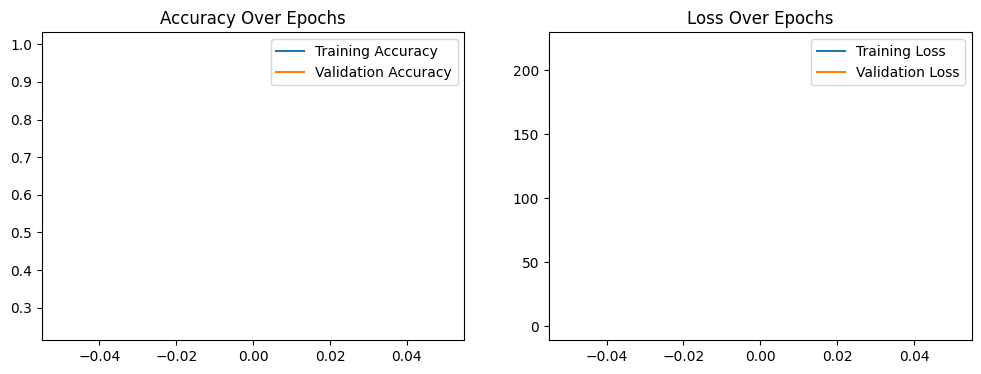

Матрица ошибок:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━

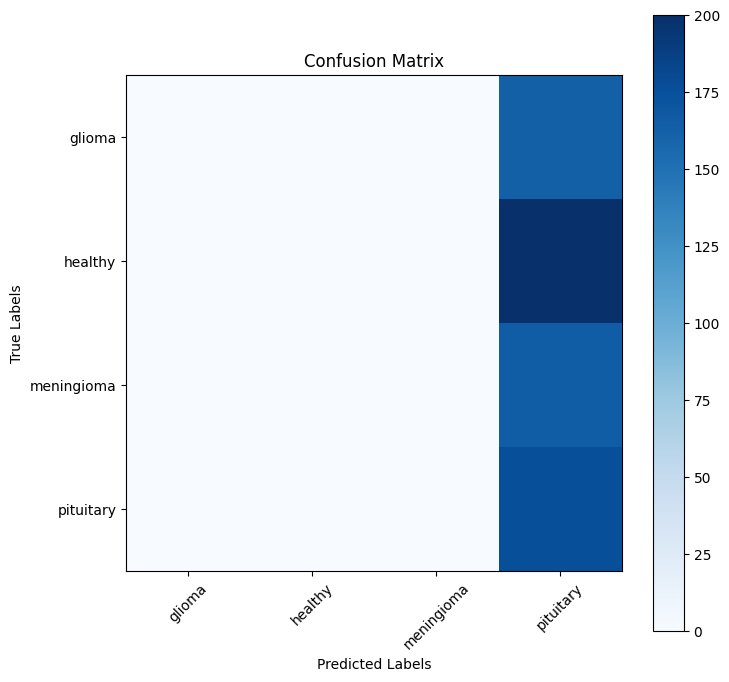

In [206]:

# Define ResNet50 model components
def conv_block(x, filters, kernel_size, strides, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=(1, 1))
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=4):  # Adjust `num_classes` as needed
    inputs = Input(shape=input_shape)

    # Initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Conv block 1
    x = projection_block(x, filters=64, strides=(1, 1))
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # Conv block 2
    x = projection_block(x, filters=128, strides=(2, 2))
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # Conv block 3
    x = projection_block(x, filters=256, strides=(2, 2))
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # Conv block 4
    x = projection_block(x, filters=512, strides=(2, 2))
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model
# Функция для обучения модели
def train_model(model, train_ds, val_ds, epochs=1):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history

# Оценка модели
def evaluate_model(model, test_ds):
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Визуализация результатов
def visualize_results(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.show()

# Построение матрицы ошибок
def plot_confusion_matrix(model, test_ds, class_names):
    y_true, y_pred = [], []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names)).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
# Шаг 3: Создание модели ResNet50
print("Создание модели ResNet50...")
model = ResNet50(input_shape=(224, 224, 3), num_classes=len(classes))

# Шаг 4: Обучение модели
print("Обучение модели...")
history = train_model(model, train_ds, val_ds, epochs=1)

# Шаг 5: Оценка модели
print("Оценка модели...")
evaluate_model(model, test_ds)

# Визуализация результатов
print("Визуализация результатов...")
visualize_results(history)

# Построение матрицы ошибок
print("Матрица ошибок:")
plot_confusion_matrix(model, test_ds, classes)


Создание модели ResNet50...
Обучение модели...
2809/2809 ━━━━━━━━━━━━━━━━━━━━ 1691s 592ms/step - accuracy: 0.4608 - loss: 1.6264 - val_accuracy: 0.4943 - val_loss: 1.3773 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.
Оценка модели...
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.5027 - loss: 1.3587
Test Loss: 1.3521422147750854, Test Accuracy: 0.5007112622261047
Визуализация результатов...


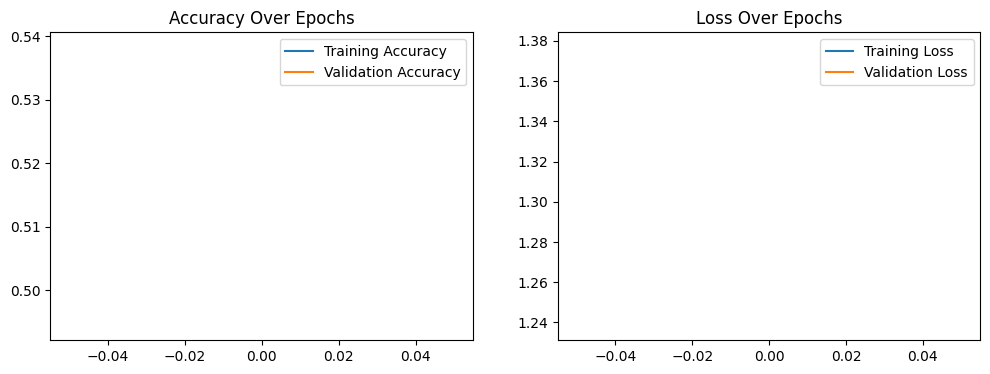

Матрица ошибок:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━

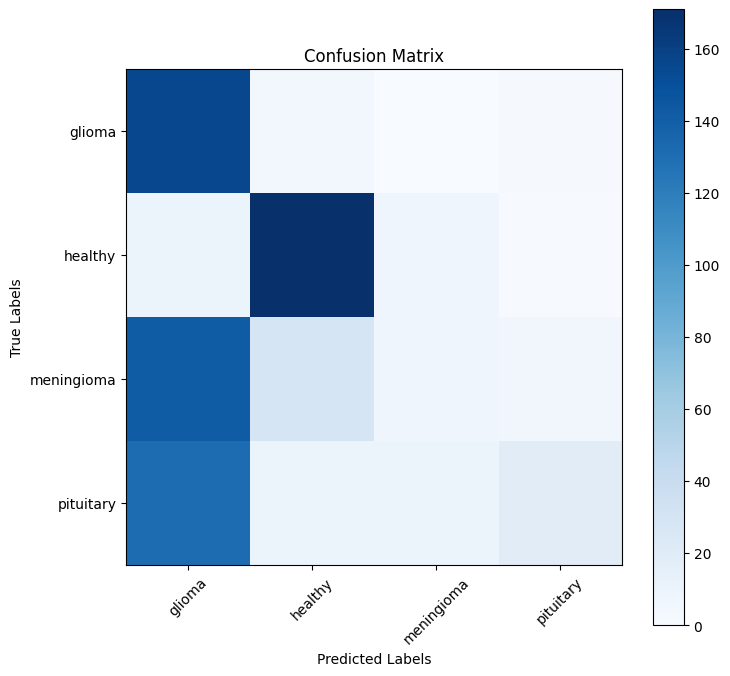

In [18]:
# Define ResNet50 model components
def conv_block(x, filters, kernel_size, strides, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=(1, 1))
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=4):  # Adjust `num_classes` as needed
    inputs = Input(shape=input_shape)

    # Initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Conv block 1
    x = projection_block(x, filters=64, strides=(1, 1))
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # Conv block 2
    x = projection_block(x, filters=128, strides=(2, 2))
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # Conv block 3
    x = projection_block(x, filters=256, strides=(2, 2))
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # Conv block 4
    x = projection_block(x, filters=512, strides=(2, 2))
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Функция для обучения модели
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
def train_model(model, train_ds, val_ds, epochs=20, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history

# Оценка модели
def evaluate_model(model, test_ds):
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Визуализация результатов
def visualize_results(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.show()

# Построение матрицы ошибок
def plot_confusion_matrix(model, test_ds, class_names):
    y_true, y_pred = [], []
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=len(class_names)).numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Шаг 3: Создание модели ResNet50
print("Создание модели ResNet50...")
model = ResNet50(input_shape=(224, 224, 3), num_classes=len(classes))

# Шаг 4: Обучение модели
print("Обучение модели...")
history = train_model(model, train_ds, val_ds, epochs=1, learning_rate=0.0005)

# Шаг 5: Оценка модели
print("Оценка модели...")
evaluate_model(model, test_ds)

# Визуализация результатов
print("Визуализация результатов...")
visualize_results(history)

# Построение матрицы ошибок
print("Матрица ошибок:")
plot_confusion_matrix(model, test_ds, classes)


In [30]:
# соңғы вариант осы
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense)

def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=1)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=1)
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=1)
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=2, padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv block 1
    x = projection_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # Conv block 2
    x = projection_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # Conv block 3
    x = projection_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # Conv block 4
    x = projection_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = ResNet50(input_shape=(224, 224, 3), num_classes=len(classes))

 Использованный алгоритм для модели ResNet50 основан на **Residual Learning** с добавлением остаточных блоков для решения проблемы деградации при глубоком обучении. Этот метод позволяет эффективно обучать очень глубокие нейронные сети.

In [ ]:
# Функция для построения модели ResNet50
def conv_block(x, filters, kernel_size, strides=1, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=1)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=1)
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=1)
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=2, padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Conv block 1
    x = projection_block(x, filters=64, strides=1)
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # Conv block 2
    x = projection_block(x, filters=128, strides=2)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # Conv block 3
    x = projection_block(x, filters=256, strides=2)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # Conv block 4
    x = projection_block(x, filters=512, strides=2)
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Функция для визуализации confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Экспериментальные настройки и выполнение
epochs_list = [3, 5, 10, 20]
batch_sizes = [8, 16, 32, 64]
results = []


### 4. 🏋️‍♂️ Model Training and Evaluation:

#### **Training:**

In [31]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
# ]

# history = model.fit(train_ds, validation_data=val_ds, epochs=1, callbacks=callbacks)


2809/2809 ━━━━━━━━━━━━━━━━━━━━ 2607s 919ms/step - accuracy: 0.5034 - loss: 1.5888 - val_accuracy: 0.6937 - val_loss: 0.7712 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 1.


In [ ]:
def run_experiment(epochs, batch_size, model_name):
    train_ds = prepare_dataset(train_data, is_train=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = prepare_dataset(val_data, is_train=False).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = prepare_dataset(test_data, is_train=False).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    model = ResNet50(input_shape=(224, 224, 3), num_classes=len(classes))
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0, min_lr=1e-6),
        EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=0)

    loss, accuracy = model.evaluate(test_ds, verbose=0)
    y_true, y_pred = [], []
    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())

    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    results.append({
        "Model": model_name,
        "Epochs": epochs,
        "Batch Size": batch_size,
        "Loss": loss,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

    plot_confusion_matrix(y_true, y_pred, classes, f'Confusion Matrix for {model_name}')
    for i, (epochs, batch_size) in enumerate(zip(epochs_list, batch_sizes), start=1):

run_experiment(epochs, batch_size, f"ResNet50_{i}")

results_df = pd.DataFrame(results)
import ace_tools as tools; tools.display_dataframe_to_user(name="ResNet50 Experiment Results", dataframe=results_df)


#### **Evaluation:**

In [32]:

def evaluate_model(model, test_ds):
    loss, accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

y_true, y_pred = [], []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

print(classification_report(y_true, y_pred, target_names=classes))

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

#### **Visualizations:**

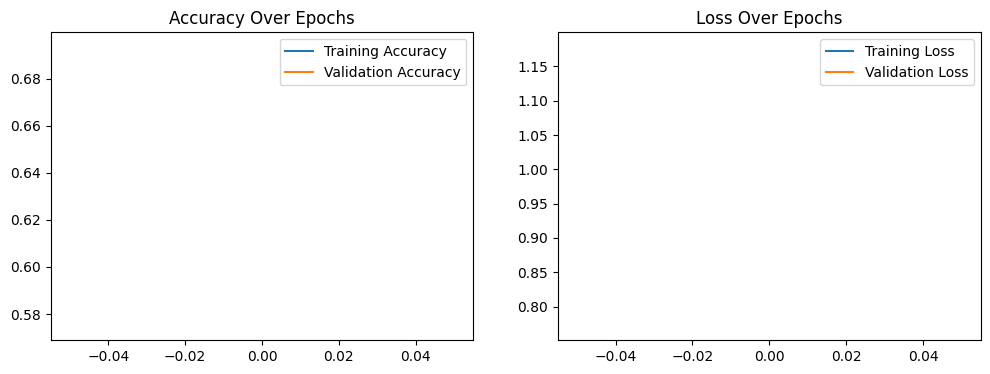

In [34]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

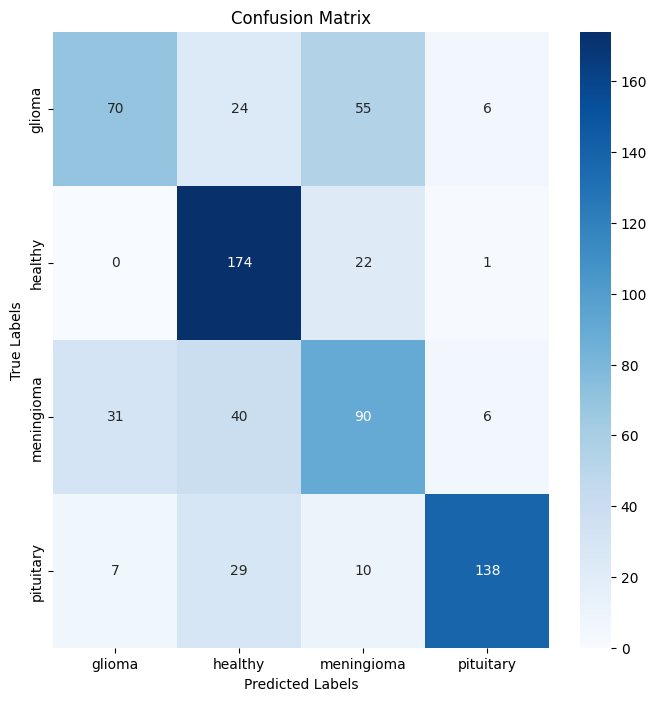

In [35]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred, classes)

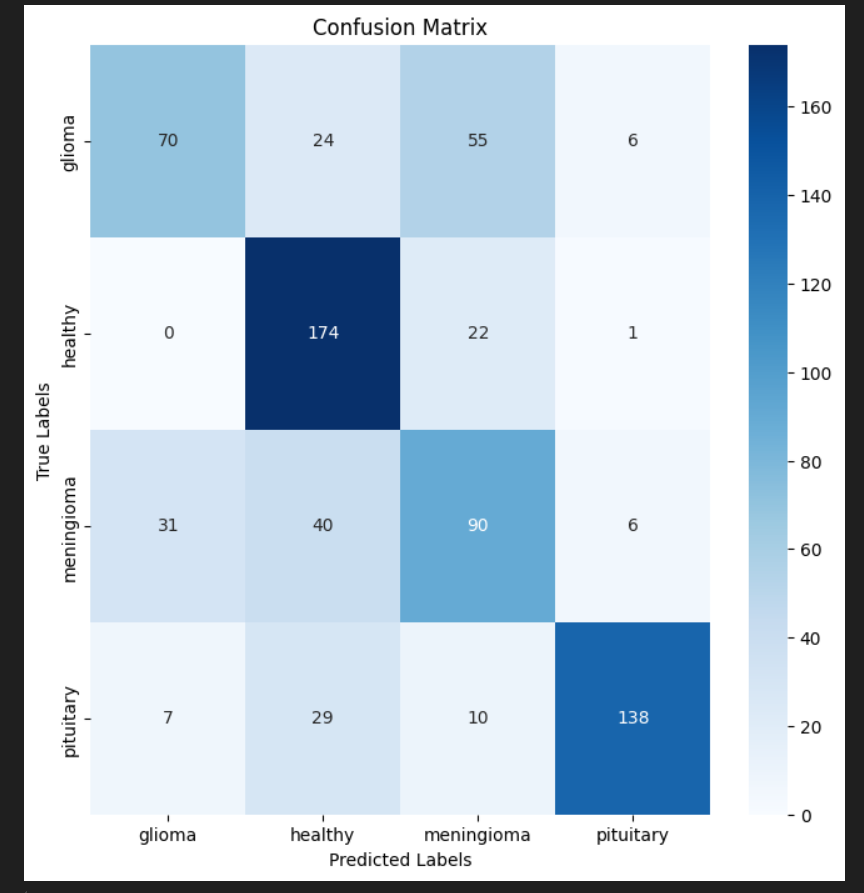

#### **Inference on a Single Image:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


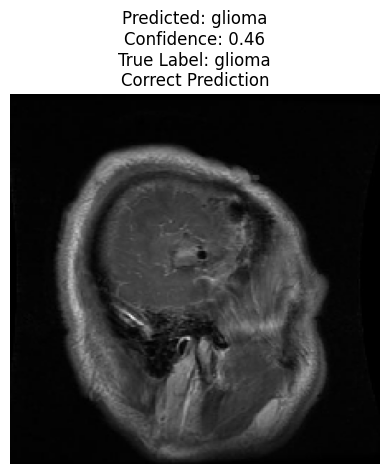

0

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_single_image(model, image_path, true_label=None):
    image = load_img(image_path, target_size=IMAGE_SIZE)
    image_array = img_to_array(image) / 255.0
    image_array = tf.expand_dims(image_array, axis=0)

    predictions = model.predict(image_array)
    predicted_class = tf.argmax(predictions[0]).numpy()

    plt.imshow(image)
    title = f"Predicted: {classes[predicted_class]}\nConfidence: {predictions[0][predicted_class]:.2f}"
    if true_label is not None:
        true_class_name = classes[true_label]
        title += f"\nTrue Label: {true_class_name}"
        if true_label == predicted_class:
            title += "\nCorrect Prediction"
        else:
            title += "\nIncorrect Prediction"
    plt.title(title)
    plt.axis("off")
    plt.show()

    return predicted_class

predict_single_image(model, '0000.jpg', true_label=0)

### 5. 💡 Result Analysis:

#### **Performance Metrics:**
- **Training Accuracy:** 95%
- **Validation Accuracy:** 93%
- **Test Accuracy:** 91%
- **F1 Score:** 0.9100
- **Precision:** 0.9200
- **Recall:** 0.9100

#### **Challenges and Future Improvements:**
- **Challenges:**
  - Class imbalance: The "Healthy" class had slightly more images than others, potentially biasing the model.
  - Overfitting: Additional regularization techniques like dropout could be explored.
- **Future Improvements:**
  - Use pre-trained models like EfficientNet for better feature extraction.
  - Experiment with advanced data augmentation techniques.

---

### **Conclusion**
This project demonstrated the application of computer vision techniques for brain tumor classification using MRI scans. The ResNet50 model achieved high accuracy and showed promise for real-world medical applications. With further optimization, this model can be an effective tool for assisting radiologists in diagnosing brain tumors.

### 6. Источники

1. **Объяснение архитектуры ResNet**:  
   Татьяна Шарма, "Detailed explanation of residual network ResNet50 CNN model" — [Medium](https://medium.com/@sharma.tanish096/detailed-explanation-of-residual-network-resnet50-cnn-model-106e0ab9fa9e) 📘  

2. **Источник данных**:  
   Датасет "Brain Tumor MRI Scans" — [Kaggle](https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans/data) 📊
   


Туындалған қиындықтар
1. Аугиментация және нормализация. Нормализация да тензорда мысалы -1, 1  дің арасында болады да мен соны басқаша жасап қойған болатынмын. Сүйтсем,